# Imports 

In [126]:
import os.path
import os
import numpy as np
import pandas as pd
from qfit.structure import Structure
import glob
from multiprocessing import Pool
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import cdist
from scipy.spatial.transform import Rotation as R
from scipy.signal import argrelextrema
from scipy import stats
import sklearn
from sklearn.cluster import MeanShift
from sklearn.cluster import  estimate_bandwidth
from sklearn.model_selection  import LeaveOneOut
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from DICT4A import DICT4A
from DICT4A_ALLAT import DICT4A_ALLAT

# functions

In [40]:
def new_dihedral(p):
    """
    Function for calculated the dihedral of a given set of 4 points.
    (not my function)
    Parameters 
    ----------
    p : nd.array, shape=(4, 3)
        4 points you want to calculate a dihedral from
    Returns
    -------
    dih_ang : float
        calculated dihedral angle
    """
    p0 = p[0]
    p1 = p[1]
    p2 = p[2]
    p3 = p[3]

    b0 = -1.0*(p1 - p0)
    b1 = p2 - p1
    b2 = p3 - p2
    b1 /= np.linalg.norm(b1)

    v = b0 - np.dot(b0, b1)*b1
    w = b2 - np.dot(b2, b1)*b1
    x = np.dot(v, w)
    y = np.dot(np.cross(b1, v), w)
    dih_ang = np.degrees(np.arctan2(y, x))
    return dih_ang

In [41]:
def rigid_transform_3D(A, B):
    '''
    * Not my function *
    from : https://github.com/nghiaho12/rigid_transform_3D/blob/master/rigid_transform_3D.py
    function for calculating the optimal rotation and transformation matrix for a set of 4 points
    onto another set of 4 points
    Input: expects 3xN matrix of points
    Returns R,t
        R = 3x3 rotation matrix
        t = 3x1 column vector
    '''
    assert A.shape == B.shape

    num_rows, num_cols = A.shape
    if num_rows != 3:
        raise Exception(f"matrix A is not 3xN, it is {num_rows}x{num_cols}")

    num_rows, num_cols = B.shape
    if num_rows != 3:
        raise Exception(f"matrix B is not 3xN, it is {num_rows}x{num_cols}")

    # find mean column wise
    centroid_A = np.mean(A, axis=1)
    centroid_B = np.mean(B, axis=1)

    # ensure centroids are 3x1
    centroid_A = centroid_A.reshape(-1, 1)
    centroid_B = centroid_B.reshape(-1, 1)

    # subtract mean
    Am = A - centroid_A
    Bm = B - centroid_B

    H = Am @ np.transpose(Bm)

    # find rotation
    U, S, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T

    t = -R @ centroid_A + centroid_B
    
    return R, t

In [298]:
def get_new_coords(all_coord_info, 
                   res, 
                   center_coords, 
                   min_ang, 
                   spread, 
                   all_density_vals, 
                   cont_dict,
                   cutoff_idx,
                   all_xyz_coords,
                   rel_b_list,
                   q_list,
                   use_cutoff=True):
    # initialize output arrays
    '''
    Function for rotating and translating the water library onto a residue. 
    Parameters
    ----------
        all_coord_info : dict with xyz coords for example 4 atoms, all 4 atoms, and all waters
        res : residue you are rotating and translating onto
        center_coords : xyz of centers of clusters
        min_ang : local minima(s) of dihedral distribution 
        spread : distance of furthers point of cluster to centroid
        all_density_vals : density value for each water point
        cont_dict : if peak continues from 180 to -180
        cutoff_idx : indices of water with density above a specified percentile
        all_xyz_coords : all xyz coords of waters
        rel_b_list : normalized b factors of waters
        q_list : occupancy of waters
        use_cutoff : boolean, whether or not to include all waters, or only
            ones above a percentile in density value.
    Returns
    -------
        new_center_coords : rotated and translated centers of clusters
        new_all_xyz_coords : rotated and translated waters
        dens_v_all : all density values
        b_all : all b factors
        q_all : all occupancy
        new_spread : spread around each cluster center
    '''
    dict_dist = {
        'Cm' : 3.0,
        'Nm' : 2.4,
        'Om' : 2.4,
        'S' : 2.4,
        'C' : 3.0,
        'N' : 2.4,
        'O' : 2.4
    }
    new_center_coords = np.array([])
    new_all_xyz_coords = np.array([])
    dens_v_all = np.array([])
    new_all_density_vals = np.array([])
    b_all = np.array([])
    q_all = np.array([])
    new_spread = np.array([])
    all_altlocs = np.unique(res.altloc) 
    for a in all_altlocs:
        poss_idx = np.where(np.array((res.altloc=='')*1 + (res.altloc==a)*1)>=1)[0] 
        name2idx = dict(zip(res.name[poss_idx], poss_idx))
      #  name2idx = dict(zip(res.name[poss_idx], np.arange(len(res.name[poss_idx]))))
        res_coords = res.coor[poss_idx]
        res_names = res.name[poss_idx]
        for atom_set_spec, atom_set_gen in DICT4A[res.resn[0]].items(): # go through each set of 4 atoms in this residue
            n_idx=[]
            contin = True
            all_atoms = [y for x in atom_set_spec
                                     for y in (x if isinstance(x, tuple) else (x,))]
            # this is to determine the dihedral angle and coordinates of atoms
            if 'YR1' in atom_set_gen or 'FR1' in atom_set_gen or 'WR1' in atom_set_gen:
                coords = []
                all_coords = []
                for at in atom_set_spec:
                    if len(at)>4: # if part of ring
                        ring_idx = [name2idx[e] for e in at]
                        if len(ring_idx) == len(at):
                            ring_coords = res.coor[ring_idx]
                            ring_com = sum(ring_coords)/len(ring_coords) 
                            coords.append(ring_com)
                            for rc in ring_coords:
                                all_coords.append(rc)
                    else: # otherwise we deal with it normally
                        coords.append(res.coor[name2idx[at]])
                        all_coords.append(res.coor[name2idx[at]])
                dih_val = new_dihedral(np.array(coords))
                bucket=[]
            else:
                for at_s in all_atoms:
                    if at_s in list(res.name):
                        n_idx.append(list(res.name).index(at_s))
                    else:
                        contin = False
                if contin == True:
                    coords = res.coor[n_idx]
                    all_coords = coords
                    dih_val = new_dihedral(np.array(coords))
                    bucket=[]
            # if dih cluster is just one peak
            if len(np.array(min_ang[tuple(atom_set_gen)])) == 0:
                dih_id = 0
            # otherwise determine the right bucket
            else:
                diff_from_mins = dih_val - np.array(min_ang[tuple(atom_set_gen)])
                closest_min_idx = np.argsort(abs(diff_from_mins))[0]
                if diff_from_mins[closest_min_idx]>0:
                    bucket.append(closest_min_idx+1)
                else:
                    bucket.append(closest_min_idx)
                if cont_dict[tuple(atom_set_gen)]:
                    bucket = np.array(bucket) + (np.array(bucket)==0)*(len(min_ang[tuple(atom_set_gen)]))
                dih_id = bucket[0]
            # this is for if we want to keep only a high density subset
            if use_cutoff:
                idx = cutoff_idx[tuple(atom_set_gen)][dih_id]
                all_wat_xyz_coords = np.array(all_xyz_coords[tuple(atom_set_gen)][dih_id])[idx]
                dens_vals = np.array(all_density_vals[tuple(atom_set_gen)][dih_id])[idx]
                bvals = np.array(rel_b_list[tuple(atom_set_gen)][dih_id])[idx]
                qvals = np.array(q_list[tuple(atom_set_gen)][dih_id])[idx]
            else:
                all_wat_xyz_coords = np.array(all_xyz_coords[tuple(atom_set_gen)][dih_id])
                dens_vals = np.array(all_density_vals[tuple(atom_set_gen)][dih_id])
                bvals = np.array(rel_b_list[tuple(atom_set_gen)][dih_id])
                qvals = np.array(q_list[tuple(atom_set_gen)][dih_id])
            p1 = all_coord_info[tuple(atom_set_gen)][dih_id][0]
            wat_centers = center_coords[tuple(atom_set_gen)][dih_id]
            sp = spread[tuple(atom_set_gen)][dih_id]
            R, t = rigid_transform_3D(np.array(p1).T, np.array(coords).T)
            new_center_coords_tmp=[]
            new_all_xyz_coords_tmp=[]
            new_spread_tmp=[]
            btemp=[]
            qtemp=[]
            dtemp=[]
            for wi, si in zip(wat_centers, sp):
                # we want to do some stuff to remove center too close to atoms in the residue
                wat_xyz=(np.dot(R, np.array(wi).T)+t.T)[0]
                dist2wat = cdist([wat_xyz], res_coords)[0]
                prod = np.full((dist2wat.shape), True)
                for d, rn in zip(dist2wat, res_names):
                    non_clash_tmp = (d>dict_dist[rn[0]])                        
                    prod = prod*non_clash_tmp
                cutoff = np.where(prod)[0]
                if len(cutoff)==len(res_coords):
                    new_center_coords_tmp.append(wat_xyz)
                    new_spread_tmp.append(si)
            for wi, bv, dv, qv in zip(all_wat_xyz_coords, bvals, dens_vals, qvals): 
                # we want to do some stuff to remove waters too close to atoms in the residue
                wat_xyz=(np.dot(R, np.array(wi).T)+t.T)[0]
                dist2wat = cdist([wat_xyz], res_coords)[0]
                prod = np.full((dist2wat.shape), True)
                for d, rn in zip(dist2wat, res_names):
                    non_clash_tmp = (d>dict_dist[rn[0]])                        
                    prod = prod*non_clash_tmp
                cutoff = np.where(prod)[0]
                if len(cutoff)==len(res_coords):
                    new_all_xyz_coords_tmp.append(wat_xyz)
                    btemp.append(bv)
                    dtemp.append(dv)
                    qtemp.append(qv)
            # add to output lists
            new_center_coords = np.append(new_center_coords, new_center_coords_tmp)
            new_all_xyz_coords = np.append(new_all_xyz_coords, new_all_xyz_coords_tmp)
            dens_v_all = np.append(dens_v_all, dtemp)
            b_all = np.append(b_all, btemp)
            q_all = np.append(q_all, qtemp)
            new_spread = np.append(new_spread, new_spread_tmp)
    return new_center_coords, new_all_xyz_coords, dens_v_all, b_all, q_all, new_spread

In [301]:
def place_all_wat(s, 
                  all_coord_info, 
                  center_coords, 
                  min_ang, 
                  spread, 
                  all_density_vals, 
                  cont_dict,
                  cutoff_idx,
                  all_xyz_coords,
                  rel_b_list,
                  q_list,
                  use_cutoff=False):
    '''
    lazy function for placing waters on a whole pdb structure
    '''
    prot = s.extract('resn', 'HOH', '!=').coor
    out_coords = np.array([])
    sz_all = np.array([])
    out_coords_all={}
    out_coords_all_dens={}
    for r in list(s.residues):
        if r.resn[0] in list(DICT4A.keys()):
            new_coords, new_all_xyz_coords, dens_v_all, b_all, q_all, new_spread = get_new_coords(all_coord_info,
                                                                                       r, 
                                                                                       center_coords, 
                                                                                       min_ang, 
                                                                                       spread, 
                                                                                       all_density_vals, 
                                                                                       cont_dict,
                                                                                       cutoff_idx,
                                                                                       all_xyz_coords,
                                                                                       rel_b_list,
                                                                                       q_list,
                                                                                       use_cutoff
                                                                                     )
            min_d = np.min(cdist(new_coords.reshape(-1,3), prot), axis=1)
            # veryyy loose cuttoff here to not include waters
            out_coords = np.append(out_coords, new_coords.reshape(-1,3)[np.where(min_d>2.1)])
            sz_all = np.append(sz_all, new_spread[np.where(min_d>2.1)])
            
            out_coords_all[(r.chain[0], r.resi[0])] = new_all_xyz_coords.reshape(-1,3)
            out_coords_all_dens[(r.chain[0], r.resi[0])] = dens_v_all
    return out_coords, out_coords_all, out_coords_all_dens, sz_all

In [43]:
def build_density_pdb(xyz_coor, fn, density):
    '''
    builds a pdb file with waters around the residue (and density in b-factor column).
    '''
    listy_wat = {}
    count=1
    # max of 10000 waters bc otherwise the pdb breaks since this is a very hacky way of building a pdb lol
    sample = len(density)//10000 + 1 
    for i, (xi, yi, zi, di) in enumerate(zip(np.array(xyz_coor)[:,0][::sample],
                                             np.array(xyz_coor)[:,1][::sample],
                                             np.array(xyz_coor)[:,2][::sample], 
                                        np.array(density)[::sample])):
        count=count+1
        listy_wat[i] = ['HETATM', str(count), 'O', 'HOH', str(count), str(format(xi, '.3f')), str(format(yi, '.3f')), str(format(zi, '.3f')), '1.00', str(format(di, '.3f')), 'O']

    file = fn
    file = open(file, "w") 
    for row in list(listy_wat.values()):
        file.write("{: >1} {: >4} {: >2} {: >5} {: >5} {: >11} {: >7} {: >7} {: >5} {: >5} {: >11}\n".format(*row))
    file.close()
    return

In [388]:
def build_center_placement_pdb(xyz_coor, pdb_fn, sphere_size_fn, spread):
    '''
    builds a pdb file with centers of clusters, as well as a pml file to size the
    centers by their spread.
    '''
    listy_wat = {}
    count=1
    for i, (xi, yi, zi) in enumerate(zip(np.array(xyz_coor)[:,0],
                                         np.array(xyz_coor)[:,1],
                                         np.array(xyz_coor)[:,2])):
        listy_wat[i] = ['HETATM', str(i+1), 'O', 'HOH', str(i+1), str(format(xi, '.3f')), str(format(yi, '.3f')), str(format(zi, '.3f')), '1.00', '1.00', 'O']
    file = pdb_fn
    file = open(file, "w") 
    for row in list(listy_wat.values()):
        file.write("{: >1} {: >4} {: >2} {: >5} {: >5} {: >11} {: >7} {: >7} {: >5} {: >5} {: >11}\n".format(*row))
    file.close()
    with open(sphere_size_fn, 'w') as f:
        for i, rad in enumerate(spread): 
            print(rad)
            f.write('show spheres, resi %s and %s\n' % (i, pdb_fn[:-4]))
            f.write('set sphere_scale, %s, resi %s and %s\n' % (rad/3, i, pdb_fn[:-4]))
    return

# load in data

In [26]:
os.chdir('/wynton/home/rotation/ckuhn/Desktop/Fraser_lab/water-scripts/4_atom_scripts/out')

In [318]:
pt=60
length = 50000
center_coords = np.load(f'center_coor_{length}_{pt}.npy',allow_pickle='TRUE').item()
cont_dict = np.load('cont_dict.npy',allow_pickle='TRUE').item()
cutoff_idx = np.load(f'cutoff_idx_{length}_{pt}.npy',allow_pickle='TRUE').item()
cutoff_idx_all = np.load(f'cutoff_idx_{length}_all.npy',allow_pickle='TRUE').item()
all_density_vals = np.load(f'density_vals_{length}_{pt}.npy',allow_pickle='TRUE').item()
labels = np.load(f'labels_{length}_{pt}.npy',allow_pickle='TRUE').item()
spread = np.load(f'spread_{length}_{pt}.npy',allow_pickle='TRUE').item()
min_ang = np.load('min_ang.npy',allow_pickle='TRUE').item()
max_ang = np.load('max_ang.npy',allow_pickle='TRUE').item()
all_coord_info = np.load('dih_info.npy',allow_pickle='TRUE').item()
all_xyz_coords = np.load(f'all_xyz_coords_{length}_{pt}.npy',allow_pickle='TRUE').item()
rel_b_list = np.load(f'rel_b_list_{length}_{pt}.npy',allow_pickle='TRUE').item()
q_list = np.load(f'q_list_{length}_{pt}.npy',allow_pickle='TRUE').item()

# Analysis

In [319]:
all_dens_vals=np.array([])
for atom_set, atom_set_val in all_density_vals.items():
    for dih, dens_val in atom_set_val.items():
        all_dens_vals = np.append(all_dens_vals, dens_val)
        
all_b_vals=np.array([])
for atom_set, atom_set_val in rel_b_list.items():
    for dih, b_val in atom_set_val.items():
        all_b_vals = np.append(all_b_vals, b_val)

all_q_vals=np.array([])
for atom_set, atom_set_val in q_list.items():
    for dih, q_val in atom_set_val.items():
        all_q_vals = np.append(all_q_vals, q_val)

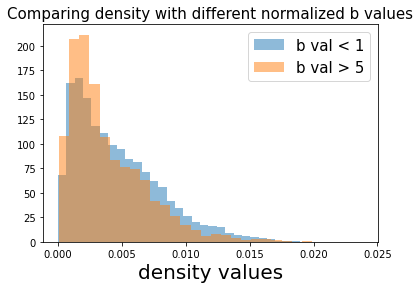

In [323]:
plt.hist(np.exp(all_dens_vals)[all_b_vals<1], density=True, alpha=.5, bins=30)
plt.hist(np.exp(all_dens_vals)[all_b_vals>5], density=True, alpha=.5, bins=30)
plt.legend(['b val < 1', 'b val > 5'], fontsize=15)
plt.title('Comparing density with different normalized b values', fontsize=15)
plt.xlabel('density values', fontsize=20)
plt.show()

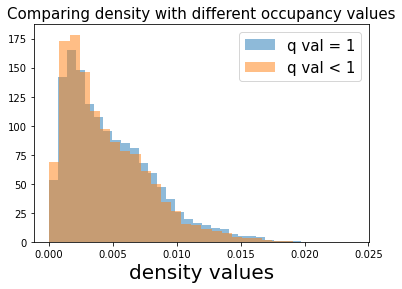

In [321]:
plt.hist(np.exp(all_dens_vals)[all_q_vals==1], density=True, alpha=.5, bins=30)
plt.hist(np.exp(all_dens_vals)[all_q_vals<1], density=True, alpha=.5, bins=30)
plt.legend(['q val = 1', 'q val < 1'], fontsize=15)
plt.title('Comparing density with different occupancy values', fontsize=15)
plt.xlabel('density values', fontsize=20)
plt.show()

In [37]:
s Structure.fromfile('/wynton/home/rotation/ckuhn/Desktop/Fraser_lab/pdb_files/download2/all2/3US6/3US6.pdb').reorder()

In [390]:
res = list(s.residues)[142]

In [391]:
new_coords, new_all_xyz_coords, dens_v_all, b_all, q_all, new_spread = get_new_coords(all_coord_info,
                                                                                       res, 
                                                                                       center_coords, 
                                                                                       min_ang, 
                                                                                       spread, 
                                                                                       all_density_vals, 
                                                                                       cont_dict,
                                                                                       cutoff_idx,
                                                                                       all_xyz_coords,
                                                                                       rel_b_list,
                                                                                       q_list,
                                                                                       use_cutoff=False
                                                                                     )

In [392]:
build_density_pdb(new_all_xyz_coords.reshape(-1,3), 
                  '3us6_test_all_res_144_2.pdb', 
                  np.exp(dens_v_all))

In [389]:
build_center_placement_pdb(new_coords.reshape(-1,3), 
                           '3us6_test_centers.pdb',
                           '3us6_test_centers.pml', 
                           new_spread)

2.0418458598324944
2.1972018338152557
2.202457743268116
1.7925537660399933
1.9355408531237424
1.9391968118988492
1.9373271350744916
1.9542196876866456
1.8290801363687195
2.8222663918479864
2.6694740177939997
1.951258604789003
2.0418458598324944
2.1972018338152557
2.202457743268116
1.7925537660399933
1.9355408531237424
1.9391968118988492
1.9373271350744916
1.9542196876866456
1.8290801363687195
2.8222663918479864
2.6694740177939997
1.951258604789003


In [ ]:
out_coords, out_coords_all, out_coords_all_dens, sz_all = place_all_wat(all_coord_info,
                                                                       s, 
                                                                       center_coords, 
                                                                       min_ang, 
                                                                       spread, 
                                                                       all_density_vals, 
                                                                       cont_dict,
                                                                       cutoff_idx,
                                                                       all_xyz_coords,
                                                                       rel_b_list,
                                                                       q_list,
                                                                       use_cutoff=False
                                                                       )